In [1]:
!pip install tensorflow scikit-learn statsmodels pandas matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Drive
PROJECT_DIR = "/content/drive/MyDrive/Attention_LSTM_Project"
import os
os.makedirs(PROJECT_DIR, exist_ok=True)
PROJECT_DIR


Mounted at /content/drive


'/content/drive/MyDrive/Attention_LSTM_Project'

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Input, LSTM, Dense
from tensorflow.keras.models import Model

from statsmodels.tsa.stattools import adfuller


In [4]:
T = 2200
SEQ_LEN = 60
H = 24

np.random.seed(42)
tf.random.set_seed(42)

t = np.arange(T)
season1 = 10 * np.sin(2 * np.pi * t / 200)
season2 = 3 * np.sin(2 * np.pi * t / 50 + 0.5)
trend = 0.01 * t

features = np.zeros((T, 5))
features[:,0] = trend + season1 + 0.5*np.random.randn(T)
features[:,1] = 0.5*trend + season2 + 0.3*np.random.randn(T)
features[:,2] = np.convolve(np.random.randn(T), np.ones(5)/5, mode='same') + 0.2*t/T
features[:,3] = 2*np.sin(2*np.pi*t/365) + 0.2*np.random.randn(T)
features[1:,4] = 0.3*features[:-1,0] + 0.2*features[:-1,1] + 0.05*np.random.randn(T-1)
features[0,4] = features[1,4]

dates = pd.date_range("2015-01-01", periods=T, freq="D")
df = pd.DataFrame(features, index=dates, columns=[f"f{i+1}" for i in range(5)])

weights = np.array([0.4, 0.3, 0.1, 0.15, 0.05])
y = df.values.dot(weights) + 0.5*np.sin(2*np.pi*t/30) + 0.5*np.random.randn(T)
df["y"] = y

df.head()


,f1,f2,f3,f4,f5,y
2015-01-01,0.248357,1.979581,0.135990,-0.257896,0.429628,0.547215
2015-01-02,0.254975,1.704635,0.205800,0.046117,0.429628,0.177226
2015-01-03,0.971749,2.273756,0.180856,0.251367,0.359734,1.564397
2015-01-04,1.732598,1.933473,0.252863,0.187583,0.771108,2.214329
2015-01-05,1.176256,2.261776,0.015523,0.125674,0.938229,1.965515


In [5]:
dataset_path = f"{PROJECT_DIR}/dataset.csv"
df.to_csv(dataset_path)
dataset_path


'/content/drive/MyDrive/Attention_LSTM_Project/dataset.csv'

In [6]:
train_size = int(0.8 * T)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

feature_cols = [f"f{i+1}" for i in range(5)]

scaler_X = StandardScaler().fit(train_df[feature_cols])
scaler_y = StandardScaler().fit(train_df[['y']])

X_scaled = scaler_X.transform(df[feature_cols])
y_scaled = scaler_y.transform(df[['y']]).flatten()

# ADF tests
adf_results = {}
for col in ['y'] + feature_cols:
    stat, pval, _, _, crit, _ = adfuller(df[col])
    adf_results[col] = {"ADF": stat, "p-value": pval, "critical": crit}

pd.DataFrame(adf_results).T


,ADF,p-value,critical
y,-2.635809,0.08582,"{'1%': -3.433354598560517, '5%': -2.8628673297..."
f1,-7.14156,0.0,"{'1%': -3.4333629045681398, '5%': -2.862870997..."
f2,-0.556664,0.880477,"{'1%': -3.4333629045681398, '5%': -2.862870997..."
f3,-6.984374,0.0,"{'1%': -3.433361517045919, '5%': -2.8628703845..."
f4,-5.710226,0.000001,"{'1%': -3.4333629045681398, '5%': -2.862870997..."
f5,-2.635855,0.085811,"{'1%': -3.4333601308010926, '5%': -2.862869772..."


In [7]:
def create_sequences(X, y, seq_len=SEQ_LEN, horizon=H):
    xs, ys = [], []
    for i in range(len(X) - seq_len - horizon):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len : i+seq_len+horizon])
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_scaled)
X_train = X_all[:int(len(X_all)*0.8)]
y_train = y_all[:int(len(y_all)*0.8)]
X_val = X_all[int(len(X_all)*0.8):int(len(X_all)*0.9)]
y_val = y_all[int(len(y_all)*0.8):int(len(y_all)*0.9)]
X_test = X_all[int(len(X_all)*0.9):]
y_test = y_all[int(len(y_all)*0.9):]

X_train.shape, X_val.shape, X_test.shape


((1692, 60, 5), (212, 60, 5), (212, 60, 5))

In [9]:
class AttentionLayer(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super().__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform")
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros")
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer="glorot_uniform")

    def call(self, inputs):
        uit = K.tanh(K.dot(inputs, self.W) + self.b)
        ait = K.dot(uit, K.expand_dims(self.u))
        ait = K.squeeze(ait, -1)
        a = K.softmax(ait)
        output = tf.reduce_sum(inputs * tf.expand_dims(a, -1), axis=1)

        if self.return_attention:
            return output, a
        return output


In [12]:
def build_attention_lstm(n_features=5):
    inp = Input((SEQ_LEN, n_features))
    x = LSTM(64, return_sequences=True)(inp)
    ctx, att = AttentionLayer(return_attention=True)(x)
    x = Dense(64, activation="relu")(ctx)
    out = Dense(H)(x)
    model = Model(inp, [out, att])
    model.compile(optimizer="adam", loss=["mse", None])
    return model

def build_baseline_lstm(n_features=5):
    inp = Input((SEQ_LEN, n_features))
    x = LSTM(64)(inp)
    x = Dense(64, activation="relu")(x)
    out = Dense(H)(x)
    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model

att_model = build_attention_lstm()
base_model = build_baseline_lstm()


In [13]:
dummy_att = np.zeros((len(X_train), SEQ_LEN))

att_model.fit(X_train, [y_train, dummy_att],
              validation_data=(X_val, [y_val, np.zeros((len(X_val),SEQ_LEN))]),
              epochs=10, batch_size=32)

base_model.fit(X_train, y_train, validation_data=(X_val, y_val),
               epochs=10, batch_size=32)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.9082 - val_loss: 0.5539
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.3188 - val_loss: 0.3742
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0779 - val_loss: 0.1013
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0463 - val_loss: 0.0854
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0396 - val_loss: 0.0807
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0359 - val_loss: 0.0776
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0335 - val_loss: 0.0732
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0319 - val_loss: 0.0688
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0305 - val_loss: 0.0648
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0294 - val_loss: 0.0620
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.7852 - val_loss: 0.3219
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.143

In [14]:
yhat_att, att_scores = att_model.predict(X_test)
yhat_base = base_model.predict(X_test)

# inverse transform
yhat_att_inv = scaler_y.inverse_transform(yhat_att.reshape(-1,1)).reshape(yhat_att.shape)
yhat_base_inv = scaler_y.inverse_transform(yhat_base.reshape(-1,1)).reshape(yhat_base.shape)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step


In [15]:
def metrics(true, pred):
    t, p = true.flatten(), pred.flatten()
    rmse = math.sqrt(mean_squared_error(t,p))
    mae = mean_absolute_error(t,p)
    mape = np.mean(np.abs((t-p)/t))*100
    return rmse, mae, mape

results = {
    "Attention": metrics(y_test_inv, yhat_att_inv),
    "Baseline": metrics(y_test_inv, yhat_base_inv)
}

pd.DataFrame(results, index=["RMSE","MAE","MAPE"])


,Attention,Baseline
RMSE,1.238600,0.966313
MAE,1.009368,0.782616
MAPE,9.324695,6.837162


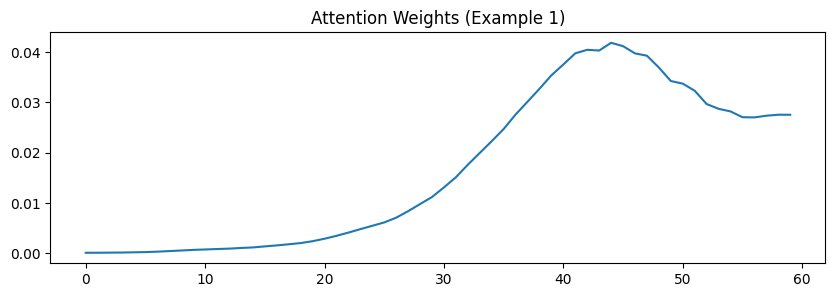

In [16]:
plt.figure(figsize=(10,3))
plt.plot(att_scores[0])
plt.title("Attention Weights (Example 1)")
plt.show()


In [17]:
results_df = pd.DataFrame(results, index=["RMSE","MAE","MAPE"])
results_df.to_csv(f"{PROJECT_DIR}/metrics.csv")

np.savetxt(f"{PROJECT_DIR}/attention_example.csv", att_scores[0], delimiter=",")

print("All outputs saved to Google Drive:", PROJECT_DIR)


All outputs saved to Google Drive: /content/drive/MyDrive/Attention_LSTM_Project
